In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt

In [2]:
train = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
test = pd.read_csv("../input/tensorflow-great-barrier-reef/test.csv")
# ss = pd.read_csv("../input/tensorflow-great-barrier-reef/example_sample_submission.csv")

train.shape, test.shape

((23501, 6), (3, 5))

In [3]:
train['annotations'] = train['annotations'].apply(lambda x: eval(x)) # annotationsが文字列として入っているため、eval()
train['n_annotations'] = train['annotations'].apply(len)

In [4]:
train.dtypes

video_id           int64
sequence           int64
video_frame        int64
sequence_frame     int64
image_id          object
annotations       object
n_annotations      int64
dtype: object

In [8]:
max_annots = 0
max_id = "" 
video_id = 0
for video_frame in range(1001, 1020):
    image_id = f'{video_id}-{video_frame}'
    len_annots = train[train['image_id']==image_id]['n_annotations'].item()
    if len_annots > max_annots:
        max_annots = len_annots
        max_id = image_id

print(max_id)
print(max_annots)

0-1001
1


In [9]:
# max_annots = 0
# max_id = "" 
# for video_id in range(1,4):
#     for video_frame in range(10001, 10020):
#         image_id = f'{video_id}-{video_frame}'
#         len_annots =  train[train['image_id']==image_id]['n_annotations'].item()
#         if len_annots > max_annots:
#             max_annots = len_annots
#             max_id = image_id
                        
# print(max_id)
# print(max_annots)

- image_id 0-1001か1-10001を使う

In [10]:
max_id

'0-1001'

In [11]:
max_bboxes = train[train['image_id']==max_id]['annotations'].item()
max_bboxes

[{'x': 938, 'y': 339, 'width': 81, 'height': 50}]

- 可視化パクリ元
https://www.kaggle.com/remekkinas/yolox-training-pipeline-cots-dataset-lb-0-507

In [12]:
import cv2
from PIL import Image
image_path = '../input/tensorflow-great-barrier-reef/train_images/video_0/1001.jpg'

In [76]:
# 可視化用関数
def draw_bboxes(img, bboxes):
    for i in range(len(bboxes)):
            box = bboxes[i]
            x0 = int(box[0])
            y0 = int(box[1])
            x1 = x0 + int(box[2])
            y1 = y0 + int(box[3])
            cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
    return img

def draw_bboxes_predict(img, bboxes, scores, bbclasses, confthre, classes_dict):
    img = draw_bboxes(img, bboxes)
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = int(bbclasses[i])
            score = scores[i]
            if score < confthre:
                continue
            cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (box[0], box[1] - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,255,0), thickness = 1)
    return img

def display_cv2img(cv2_img):
    out_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(out_img))

In [77]:
sample_img = cv2.imread(image_path)
sample_bboxes = [list(_.values()) for _ in max_bboxes]

# display cv2 image with bbox

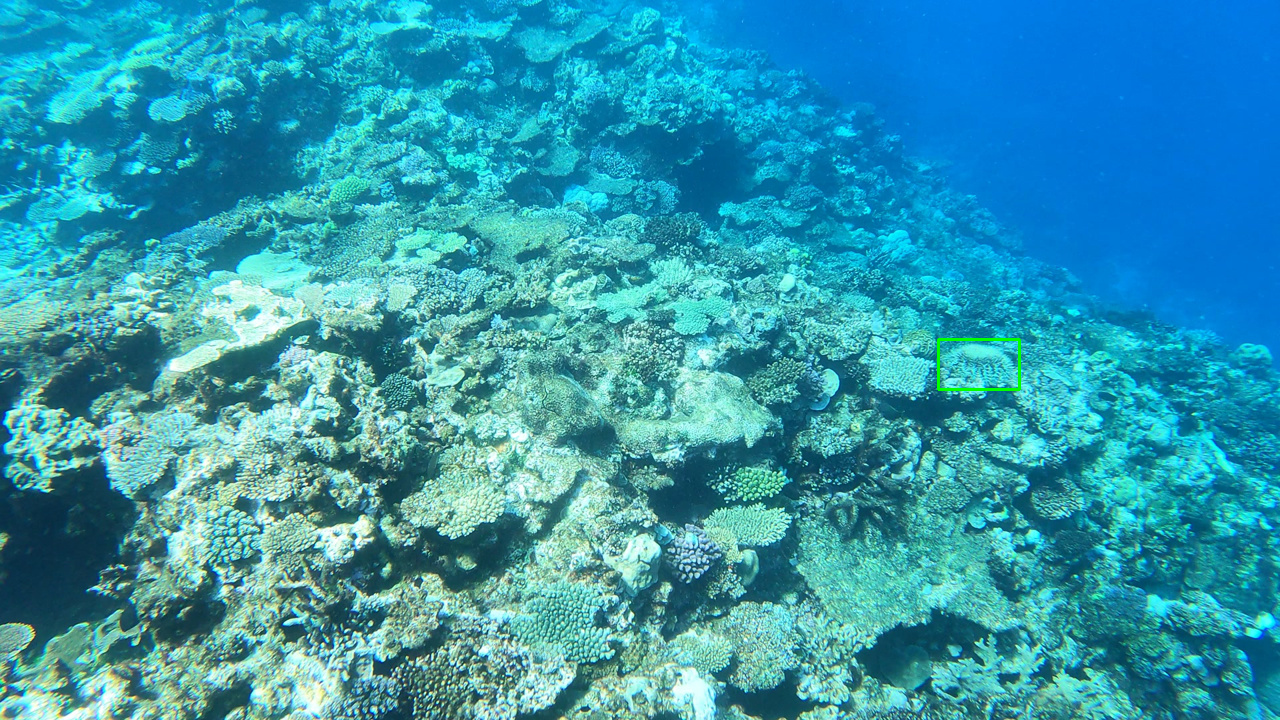

In [83]:
out_image = draw_bboxes(sample_img, sample_bboxes)
display_cv2img(out_image)    # Since we load image using OpenCV we have to convert it 

- 推論時想定可視化サンプル

In [80]:
# # Get predictions
# # bboxes, bbclasses, scores = yolox_inference(img, model, test_size)
# bboxes, bbclasses, scores = sample_bboxes, [0], [0.99]
# # Draw predictions
# out_image = draw_bboxes_predict(sample_img, bboxes, scores, bbclasses, 0.0, {0: 'hitode'})

# # Since we load image using OpenCV we have to convert it 
# out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
# display(Image.fromarray(out_image))

# Augmentation
- 参考: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [18]:
import albumentations as A

In [19]:
out_image.shape

(720, 1280, 3)

In [85]:
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=100, min_visibility=0.1, label_fields=[]))

In [86]:
transformed = transform(image=sample_img, bboxes=sample_bboxes)
transformed_img = transformed['image']
transformed_bboxes = transformed['bboxes']

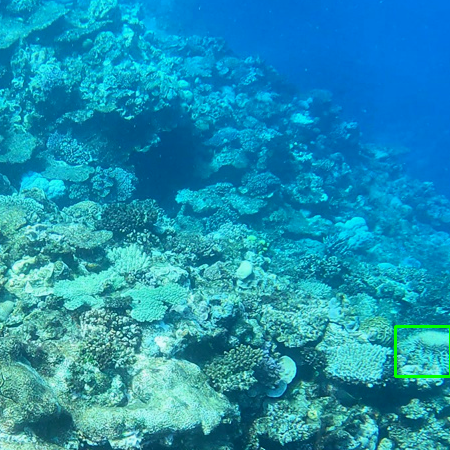

In [90]:
transformed_img = draw_bboxes(transformed_img, transformed_bboxes)
display_cv2img(transformed_img)

In [88]:
transformed_img.shape

(450, 450, 3)

In [26]:
sample_bboxes

[[938, 339, 81, 50]]